In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import h5py
import plots
import pystan
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
from true_params import true_params

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1det = array(f['posteriors/m1det'])
    m2det = array(f['posteriors/m2det'])
    dldet = array(f['posteriors/dl'])
    
    m1true = array(f['m1s'])
    m2true = array(f['m2s'])
    ztrue = array(f['zs'])

In [4]:
with h5py.File('selected.h5', 'r') as f:
    m1sel = array(f['m1det'])
    m2sel = array(f['m2det'])
    dlsel = array(f['dl'])
    logwtsel = log(array(f['wt']))
    N_gen = f.attrs['N_gen']

In [5]:
N = 128
Nsamp = 16
Nsel = 16384

m1 = []
m2 = []
dl = []
bw = []
for i in range(N):
    s = random.choice(m1det.shape[1], size=Nsamp, replace=False)
    m1.append(m1det[i,s])
    m2.append(m2det[i,s])
    dl.append(dldet[i,s])
    
    pt = column_stack((m1det[i,:], m2det[i,:], dldet[i,:]))
    bw.append(cov(pt, rowvar=False)/Nsamp**(2.0/7.0))
    
m1 = array(m1)
m2 = array(m2)
dl = array(dl)
bw = array(bw)
    
s = random.choice(m1sel.shape[0], size=Nsel, replace=False)
m1s = m1sel[s]
m2s = m2sel[s]
dls = dlsel[s]
logwts = logwtsel[s]
N_gens = int(round(N_gen*Nsel/float(len(m1sel))))

In [61]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19fdc175f8be3fe9fea64fe24b544b9d NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmprydy84xh/stanfit4anon_model_19fdc175f8be3fe9fea64fe24b544b9d_8964142296696618131.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [62]:
Ninterp = 500
zMax = 8

data = {
    'nobs': N,
    'nsel': Nsel,
    
    'nsamp': Nsamp,
    
    'Tobs': 0.5*5*N/float(m1det.shape[0]),
    'N_gen': N_gens,
    
    'm1obs': m1,
    'm2obs': m2,
    'dlobs': dl,
    'bw': bw,
    
    'm1sel': m1s,
    'm2sel': m2s,
    'dlsel': dls,
    'log_wtsel': logwts,
    
    'ninterp': Ninterp,
    'zinterp': expm1(linspace(log(1), log(1+zMax), 500)),
    
    'cosmo_prior': 0
}

In [75]:
fit = model.sampling(data=data, iter=100)

In [66]:
p0 = {
    'H0': 70.,
    'Omh2': 0.3*0.7**2,
    'w': -1,
    'w_a': 0,
    'MMax': 50,
    'alpha': 1.1,
    'beta': 0.0,
    'gamma': 3.0,
    'm1s': m1true[:N],
    'm2_frac': (m2true[:N]-5)/(m1true[:N]-5),
    'zs': ztrue[:N]
}

In [67]:
fit.log_prob(fit.unconstrain_pars(p0), adjust_transform=False)

-631.9476577218397

In [68]:
def f(x):
    p = p0.copy()
    p['w_a'] = x
    return fit.log_prob(fit.unconstrain_pars(p), adjust_transform=False)

In [71]:
xs = linspace(-1, 1, 100)
ys = array([f(x) for x in xs])

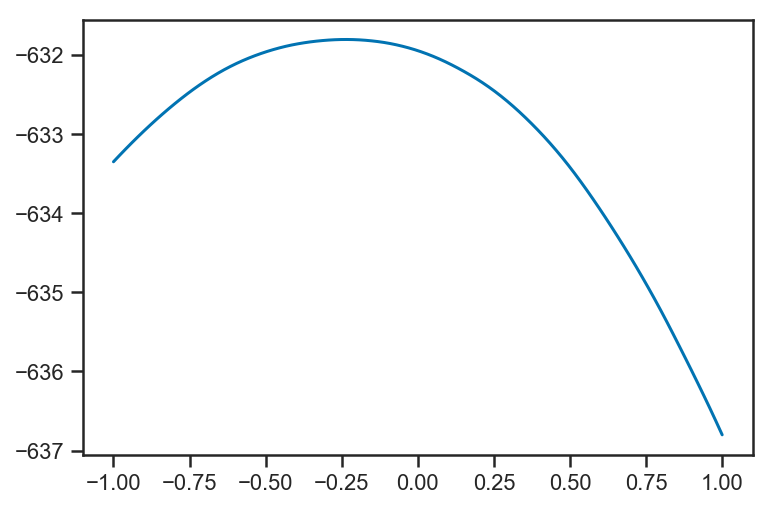

In [72]:
plot(xs, ys)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c49a649b0>,
      dtype=object)

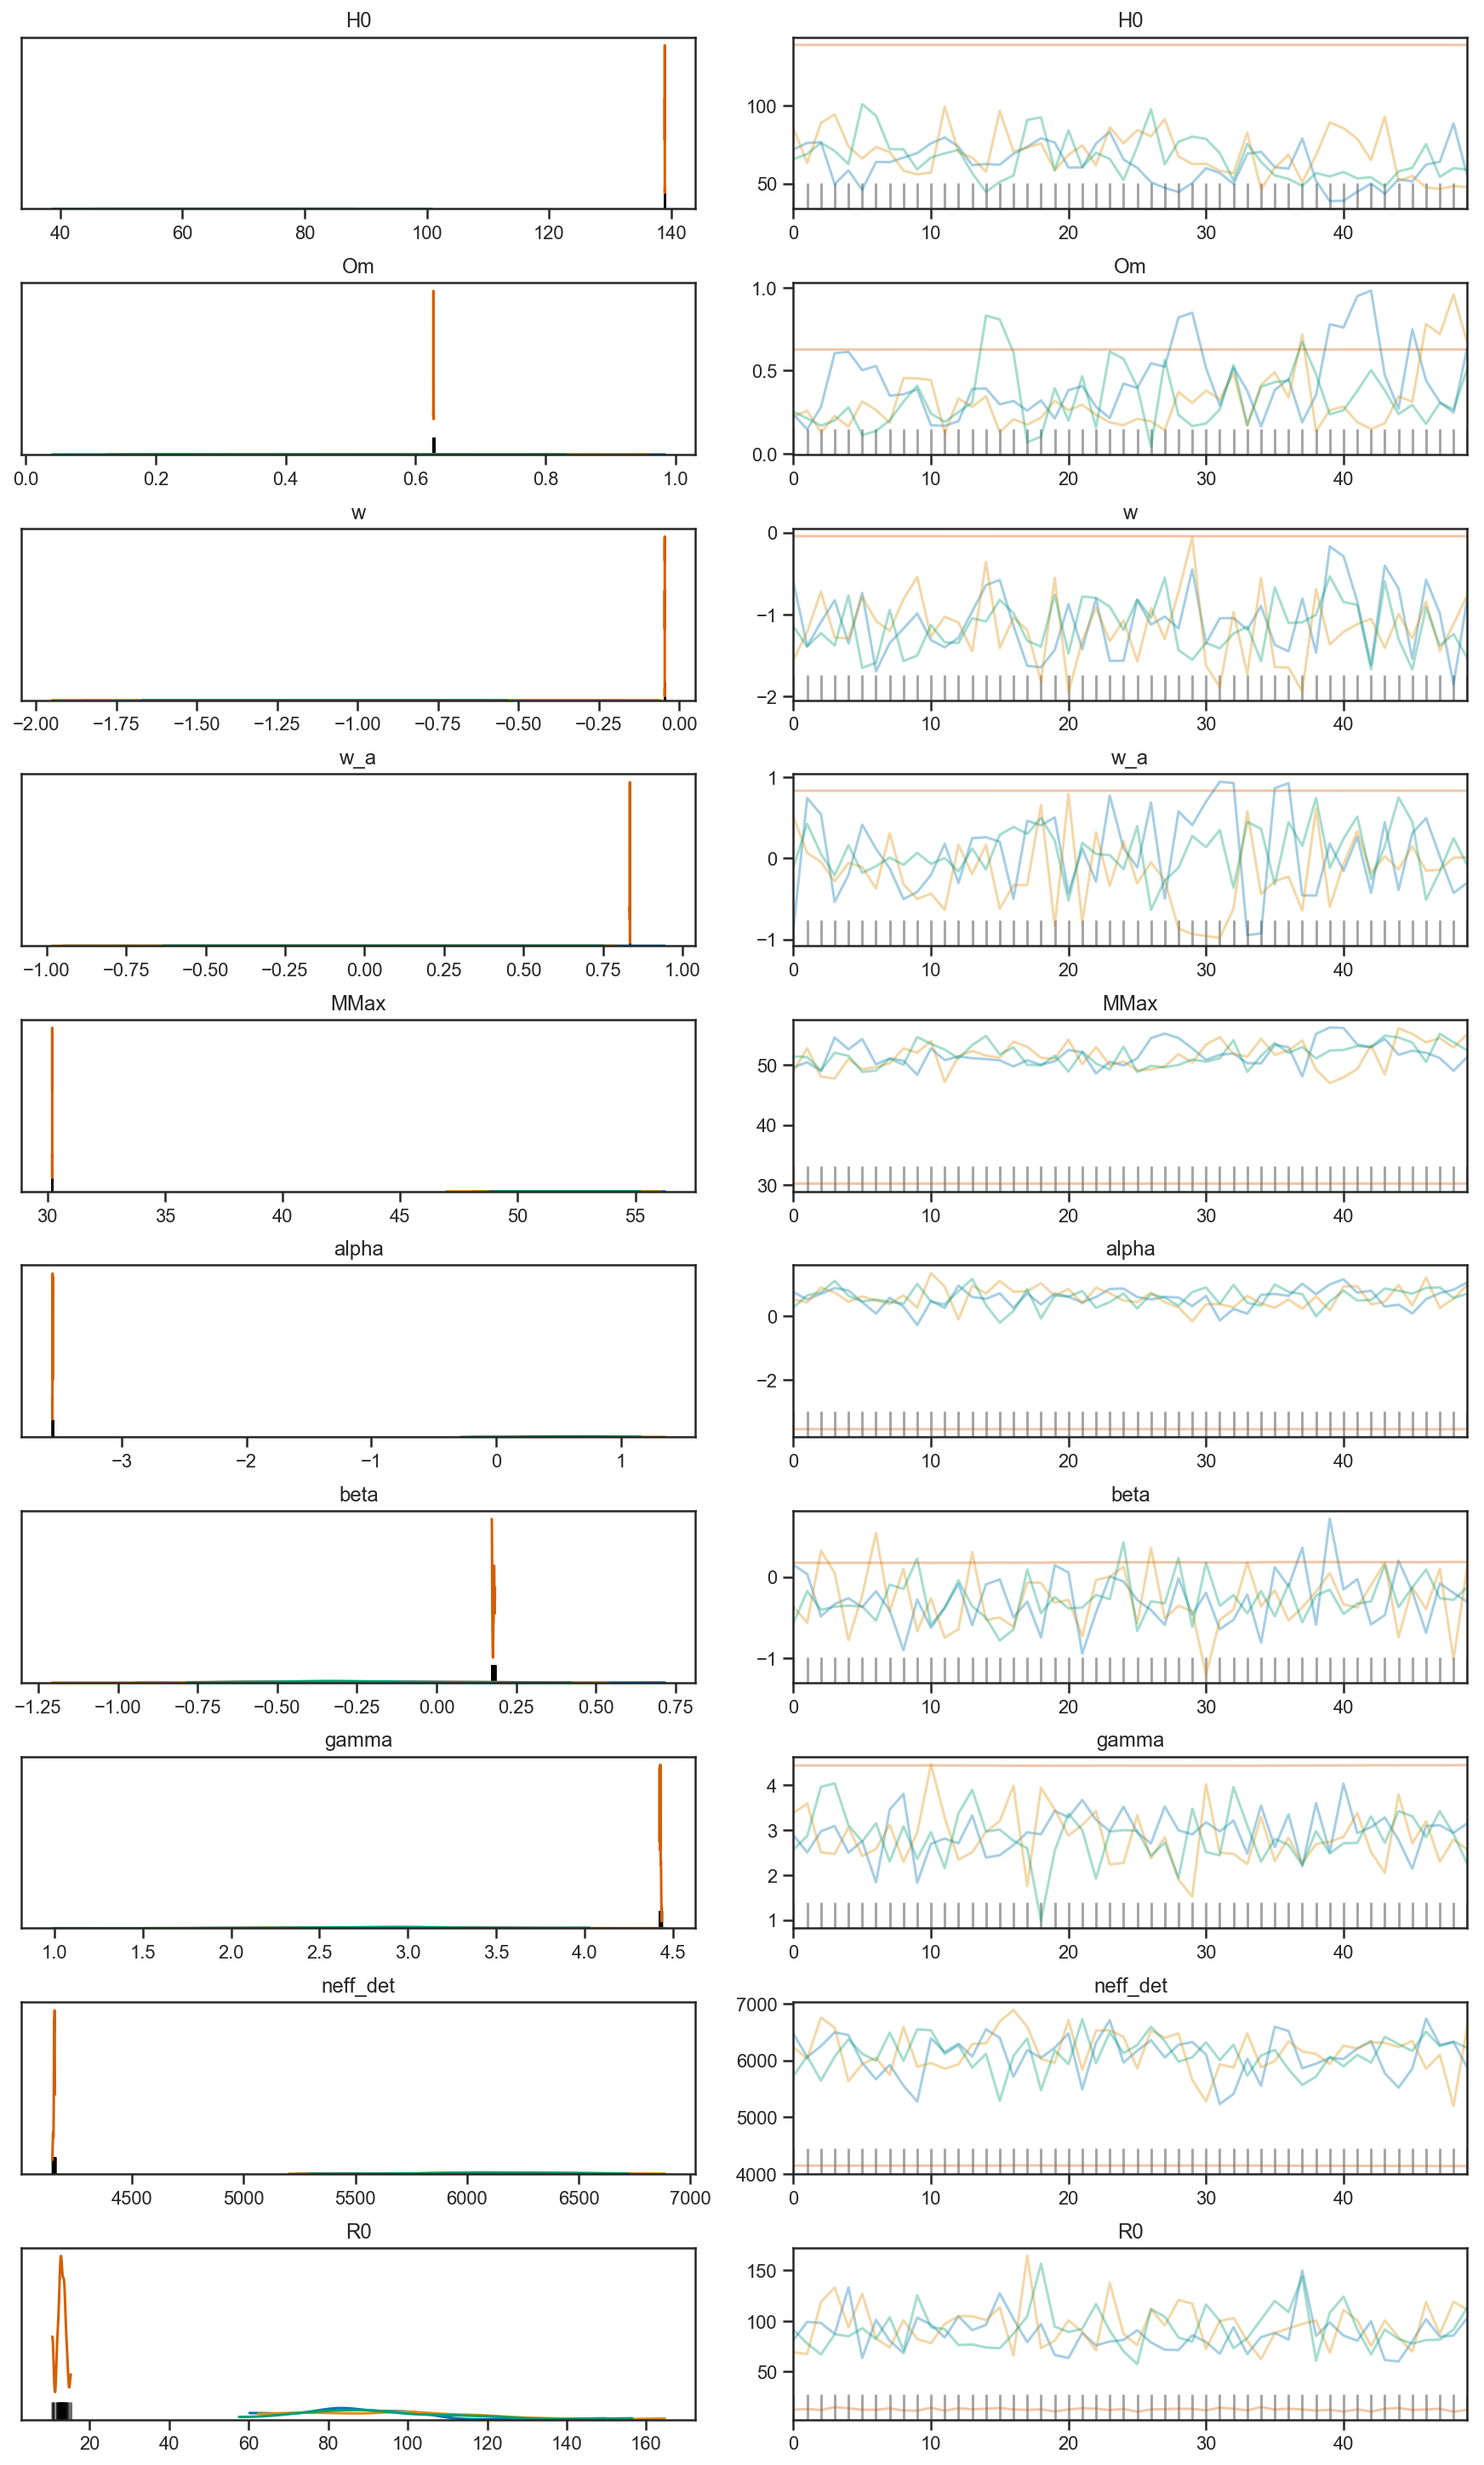

In [76]:
az.plot_trace(fit, var_names=['H0', 'Om', 'w', 'w_a', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'neff_det', 'R0'])

In [77]:
c = fit.extract(permuted=True)

In [81]:
for k in c.keys():
    c[k] = c[k][:150,...]

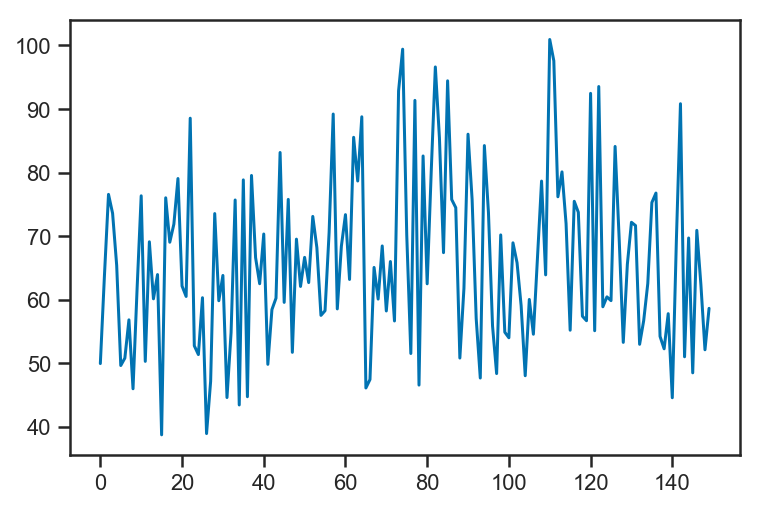

In [82]:
plot(c['H0'])

In [83]:
for k in c.keys():
    s = c[k].shape
    sp = (3, 50) + s[1:]
    c[k] = reshape(c[k], sp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c47e9a6a0>,
      dtype=object)

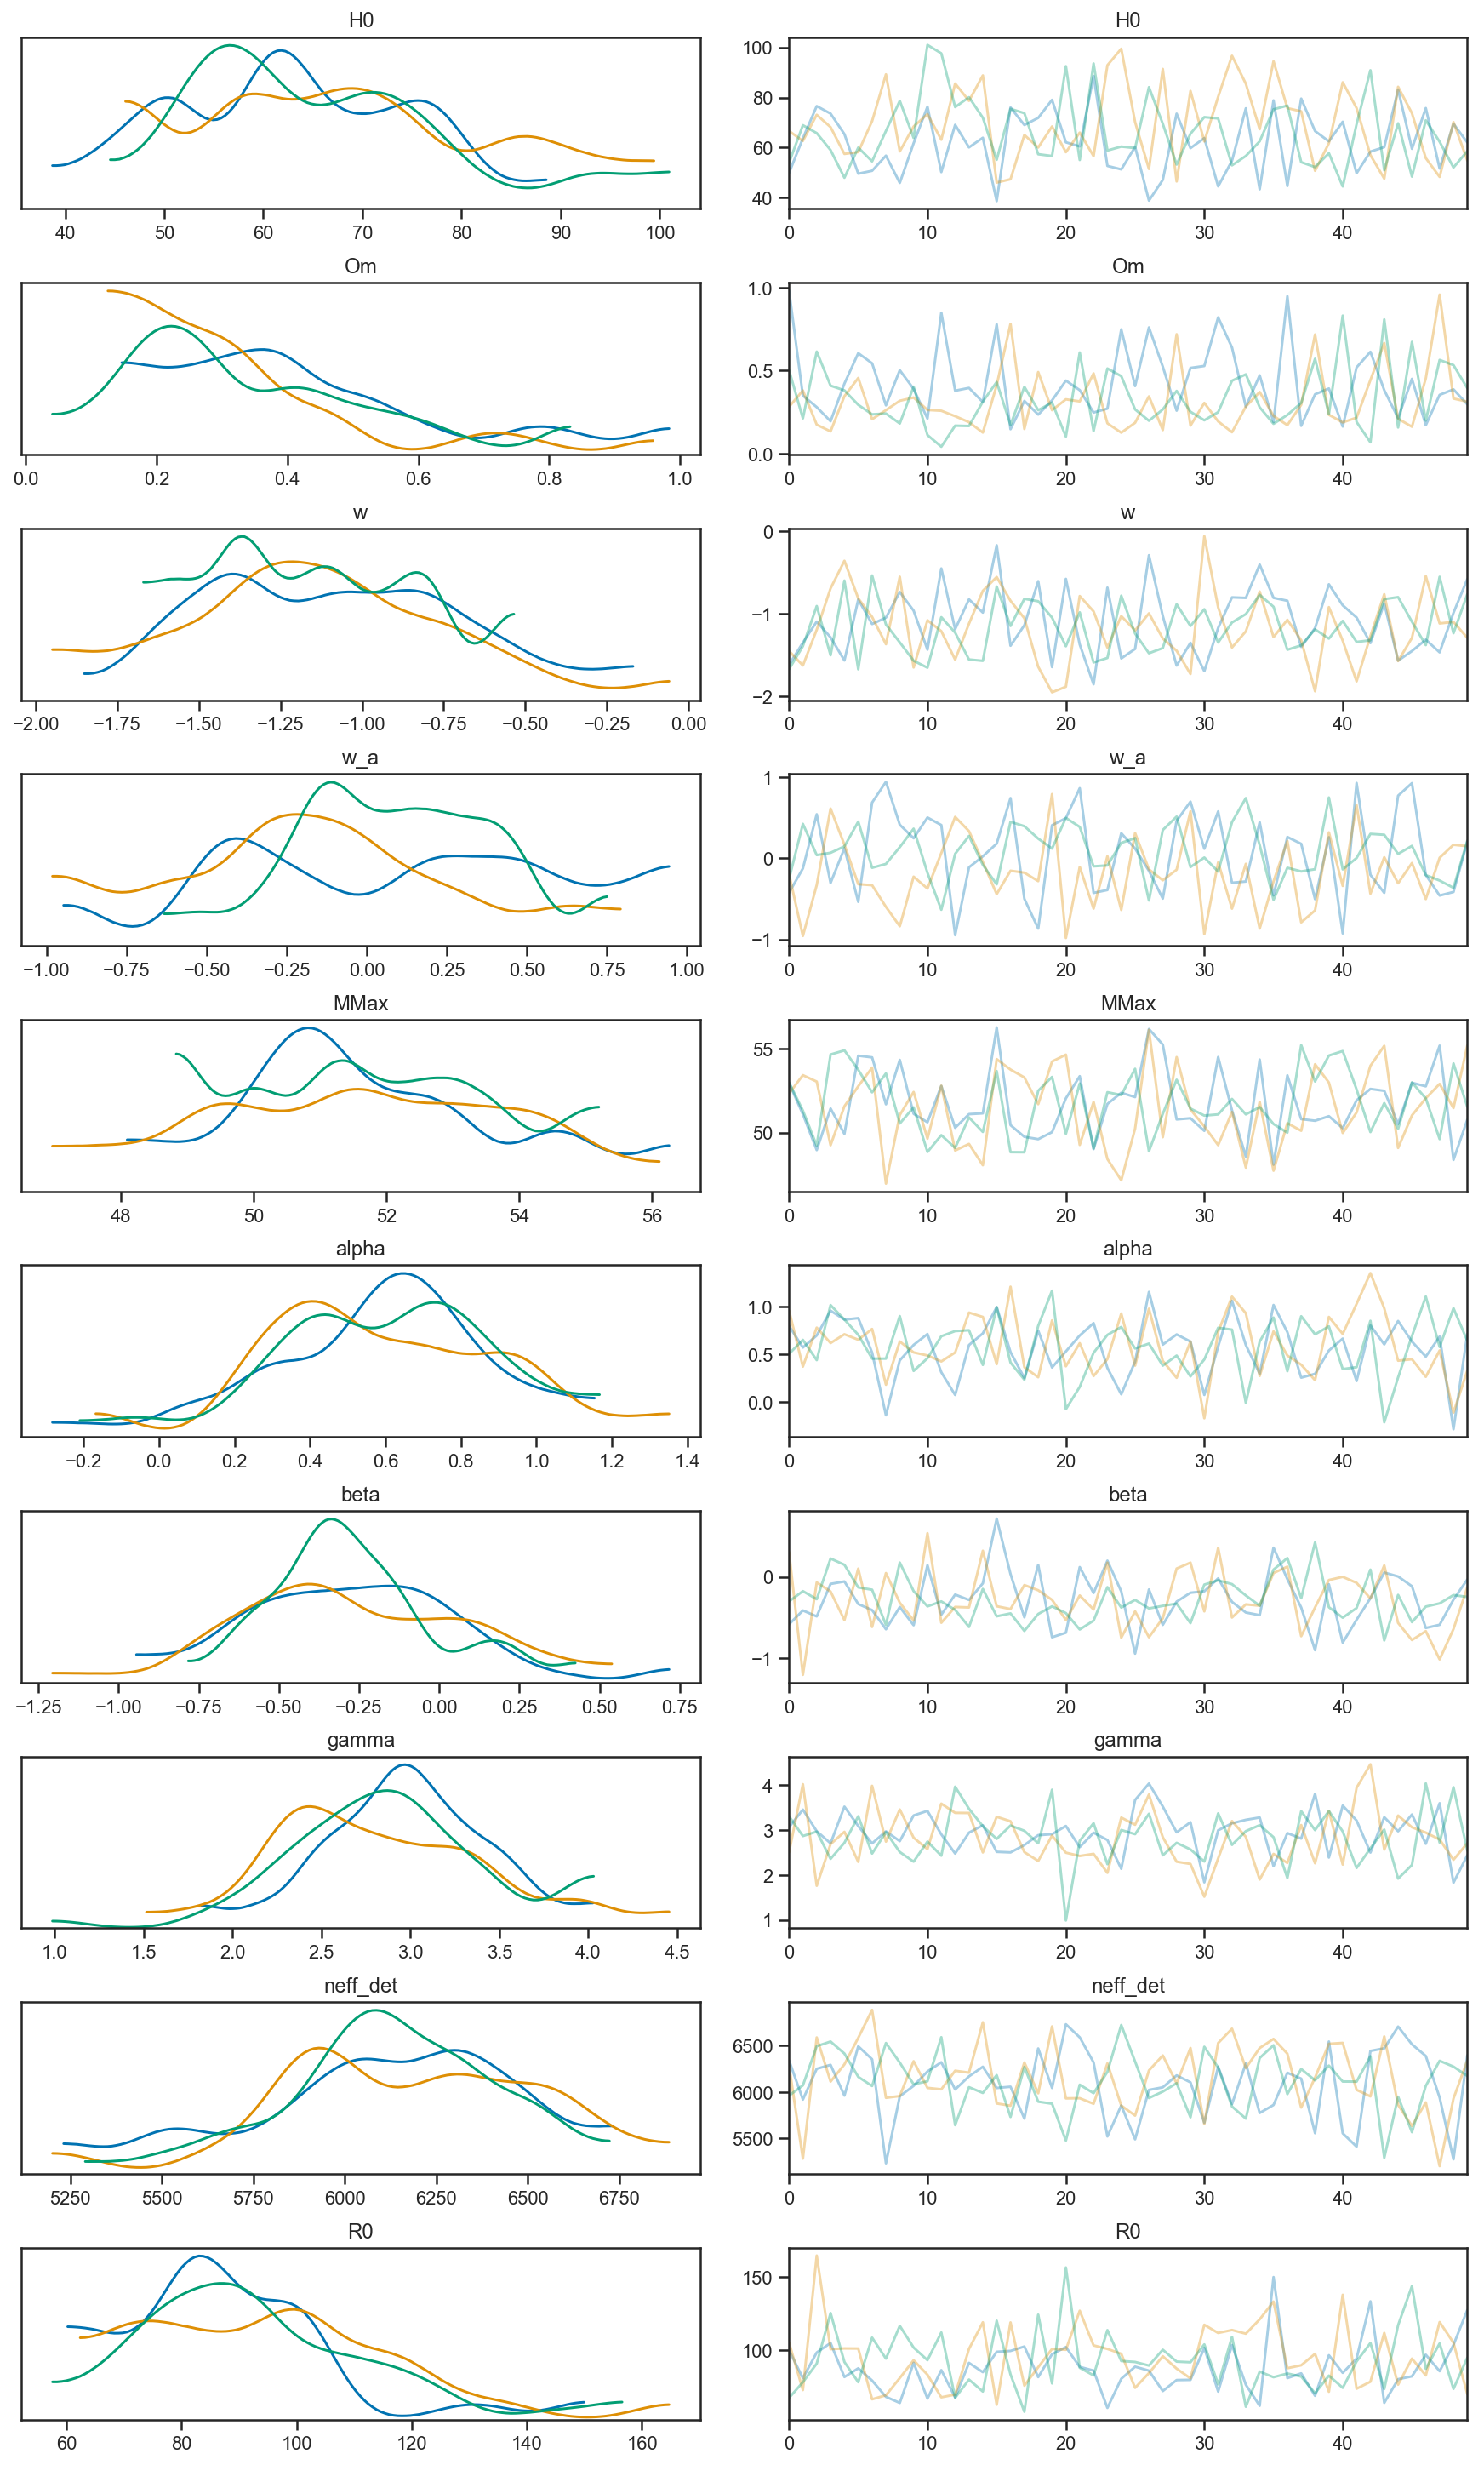

In [86]:
az.plot_trace(c, var_names=['H0', 'Om', 'w', 'w_a', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'neff_det', 'R0'])